<a href="https://colab.research.google.com/github/yonatanlou/study_projects/blob/main/Urban%20Simulation/ex4/UrbanSim4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# # Install Folium for Geographic data visualization
# !pip install folium
# # Install plotlyExpress
# !pip install plotly_express

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (1,906 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bldgs_points.cpg to bldgs_points (1).cpg
Saving bldgs_points.dbf to bldgs_points (1).dbf
Saving bldgs_points.prj to bldgs_points (1).prj
Saving bldgs_points.sbn to bldgs_points (1).sbn
Saving bldgs_points.sbx to bldgs_points (1).sbx
Saving bldgs_points.shp to bldgs_points (1).shp
Saving bldgs_points.shp.xml to bldgs_points.shp (1).xml
Saving bldgs_points.shx to bldgs_points (1).shx


In [ ]:
from random import random, choice, randint
import geopandas
import networkx as nx
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab import data_table
data_table.disable_dataframe_formatter()




In [ ]:
class Building:    
    # initialize building
    def __init__(self, geometry, landuse):
        self.geometry = geometry
        self.landuse = landuse
    
    def distance(self, n): # compute the distance between buildings and another building n
        # Euclidean distance - sqare root of (squared x differece + squared y difference)
        return ((self.geometry.x - n.geometry.x)**2 + (self.geometry.y - n.geometry.y)**2)**0.5
        
        
class Agent:
    # initialize agent
    def  __init__(self, status, budget, social_position, home, utility_value):
        self.status = status # epidemiological status
        self.budget = budget # travel budget
        self.social_position = social_position # social position
        self.home = home # home building
        self.utility_value = utility_value # minimal utility value
        
        self.location = home # set current location to home
    
    def compute_utility(self, agent): # compute utility from interaction with agent
        d = self.location.distance(agent.location) # compute distance between current locations
        if d > self.budget: # if distance is greater than budget, return 0 utility
            return 0
        d_social = abs(self.social_position - agent.social_position) # social distance
        d_costs = d/self.budget # relative utility from distance travelled
        utility = model.w1 * (1-d_social) + (1-model.w1) * (1-d_costs) # compute utility
        return utility
    
    # find candidates to choose from when moving
    def find_candidates(self):
        candidates = []
        for a1 in nx.generators.ego_graph(model.network, self, radius=3):
            if self != a1 and self.compute_utility(a1) >= self.utility_value:
                candidates.append(a1)
        return list(set(candidates))
        
    # agent action
    def mobility_model(self): # move agents in space
        if 1 <= self.status <= model.time_to_recover: # if agent if infected
            self.location = self.home # make sure agent is at home
            model.at_home +=1
        elif random() > 0.5:
            self.location = choice(model.non_residential)
        else: # if at mandatory activity - go visit friends
            candidates = self.find_candidates()
            if len(candidates) > 0: # if there are such neighbors - choose one and move to its location
                c = choice(candidates) 
                model.utility.append(self.compute_utility(c))
                self.location = c.location
            else: # if there are none - go back home
                self.location = self.home
                model.at_home +=1

                
    def contagion_model(self):        
        if 1 <= self.status <= model.time_to_recover: # if infected - increase status by 1
            self.status += 1
        elif self.status == 0: 
            # find all other agents within the same building
            choice_set = [a for a in model.network.nodes if a != self and a.location == self.location]
            if len(choice_set) > 0: # if there are such
                a = choice(choice_set) # randomly choose an agent
                a_idx = list(model.network.nodes).index(a)
                a_copy_status = model.nodes_copy[a_idx].status
                if self.status == 0 and 1 <= a_copy_status <= model.time_to_recover: # if a is infected
                    self.status = 1 # infect agent



In [ ]:

class Model:    
    def __init__(self, agents_num, time_to_recover, w1, connections, blds, simulation):
        self.time_to_recover = time_to_recover
        self.w1 = w1
        self.connections = connections
        self.simulation = simulation

        self.network = nx.Graph() # create a network element
        self.buildings = []
        self.data = []
        
        for idx, row in blds.iterrows(): # iterate through records
            self.buildings.append(Building(row.geometry, row.landuse)) # append building with geometry and landuse
        
        self.non_residential = [b for b in self.buildings if b.landuse=='commercial']
        residential = [b for b in self.buildings if b.landuse=='residential']
        for i in range(agents_num):
            # create agent with attributes status, home, activity location, social position, and utility value
            agent = Agent((random() < 0.05) * 1, randint(200, 800), random(), choice(residential), random()) 
            self.network.add_node(agent) # add agent as node to the network
        
        for a in self.network.nodes: # for every agent = for every node
            candidates = [f for f in self.network.nodes if f != a] # find all agents that are not a
            distances = [a.home.distance(f.home) for f in candidates] # compute distance from agents
            sorted_distances = sorted(distances) # sort distances from lowest to highest
            ranks = [sorted_distances.index(d) for d in distances] # get a rank score for each distance
            # choose only agents whose rank is lower than connections
            friends = [candidates[i] for i in range(len(candidates)) if ranks[i] < connections]
            for f in friends:
                self.network.add_edge(a, f) # add an edge to the network between agent and friend
    
    def simulate(self):
        # compute number of infected agents
        active_infected = len([a for a in self.network.nodes if 1 <= a.status <= self.time_to_recover])
        t = 1 # store number of iteration
        while active_infected > 0: # stop rule of simulation - no more infected cells
            self.utility = []
            self.at_home = 0
            self.nodes_copy = deepcopy(list(self.network.nodes))
            for a in self.network.nodes:
                a.mobility_model() # move
                a.contagion_model() # check infection
    
            # compute number of infected agents
            active_infected = len([a for a in self.network.nodes if 1 <= a.status <= self.time_to_recover])
            new_infected = len([a for a in self.network.nodes if 1 == a.status])
            total_infected = len([a for a in self.network.nodes if 1 <= a.status])
            mean_utility = sum(self.utility)/len(self.utility)
            self.data.append([self.w1, self.connections, self.simulation, t, 
                              new_infected, active_infected, total_infected, mean_utility, self.at_home])
            t += 1




In [ ]:
time_to_recover = 12
shape = 'bldgs_points.shp'
blds = geopandas.read_file(shape) # read shapefile
agents_num = 900
results = []
for connections in [2,6,10]:
    for w1 in [0.1, 0.5, 0.9]:
        for i in range(5):
            print(connections, w1, i)
            model = Model(agents_num, time_to_recover, w1, connections, blds, i)
            model.simulate()
            for l in model.data:
                results.append(l)

2 0.1 0
2 0.1 1
2 0.1 2
2 0.1 3
2 0.1 4
2 0.5 0
2 0.5 1
2 0.5 2
2 0.5 3
2 0.5 4
2 0.9 0
2 0.9 1
2 0.9 2
2 0.9 3
2 0.9 4
6 0.1 0
6 0.1 1
6 0.1 2
6 0.1 3
6 0.1 4
6 0.5 0
6 0.5 1
6 0.5 2
6 0.5 3
6 0.5 4
6 0.9 0
6 0.9 1
6 0.9 2
6 0.9 3
6 0.9 4
10 0.1 0
10 0.1 1
10 0.1 2
10 0.1 3
10 0.1 4
10 0.5 0
10 0.5 1
10 0.5 2
10 0.5 3
10 0.5 4
10 0.9 0
10 0.9 1
10 0.9 2
10 0.9 3
10 0.9 4


In [ ]:
df = pd.DataFrame(results, columns=['Price weight', 'Integration', 'Simulation', 'Time', 
                                    'New infected', 'Active infected', 'Total infected', 'Mean utility', 'At home'])


In [ ]:
df.head()

,Price weight,Integration,Simulation,Time,New infected,Active infected,Total infected,Mean utility,At home
0,0.1,2,0,1,25,64,64,0.889371,64
1,0.1,2,0,2,24,88,88,0.790644,181
2,0.1,2,0,3,29,117,117,0.756185,219
3,0.1,2,0,4,19,136,136,0.784649,231
4,0.1,2,0,5,19,155,155,0.767879,248


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/urbanSimData.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/urbanSimData.csv", index_col=0)

Mounted at /content/drive


In [ ]:
## 1.
df = pd.DataFrame(results, columns=['Price weight', 'Integration', 'Simulation', 'Time', 
                                    'New infected', 'Active infected', 'Total infected', 'Mean utility', 'At home'])

df.head()

NameError: ignored

In [ ]:
df.head()

,Price weight,Integration,Simulation,Time,New infected,Active infected,Total infected,Mean utility,At home
0,0.1,2,0,1,25,64,64,0.889371,64
1,0.1,2,0,2,24,88,88,0.790644,181
2,0.1,2,0,3,29,117,117,0.756185,219
3,0.1,2,0,4,19,136,136,0.784649,231
4,0.1,2,0,5,19,155,155,0.767879,248


In [ ]:
##2. 
agg_functions = {'New infected':'max', 'Active infected':'max', 'Total infected':'last', 'Mean utility':'mean',
          'Time':'max'}

# summarize variables
agg = df.groupby(['Simulation']).agg(agg_functions)
agg


,New infected,Active infected,Total infected,Mean utility,Time
Simulation,,,,,
0,75,681,869,0.732132,77
1,81,665,870,0.735656,76
2,90,686,863,0.733766,66
3,78,658,867,0.735803,64
4,79,656,878,0.738171,69


In [ ]:
##3.
agg = df.groupby(['Price weight', 'Integration', 'Simulation']).agg(agg_functions)
mean = agg.groupby(['Price weight', 'Integration']).mean()

New infected  Active infected  ...  Mean utility  Time
Price weight Integration                                 ...                    
0.1          2                    30.2            244.4  ...      0.771576  50.6
             6                    51.8            497.0  ...      0.737745  64.0
             10                   52.2            506.6  ...      0.735678  61.4
0.5          2                    32.6            276.4  ...      0.714104  45.6
             6                    64.4            587.0  ...      0.696713  55.0
             10                   62.0            569.0  ...      0.698377  59.6
0.9          2                    31.0            263.8  ...      0.755807  47.8
             6                    77.8            642.8  ...      0.755967  54.2
             10                   76.2            663.2  ...      0.760633  45.2

[9 rows x 5 columns]

In [ ]:
mean.columns

Index(['New infected', 'Active infected', 'Total infected', 'Mean utility',
       'Time'],
      dtype='object')

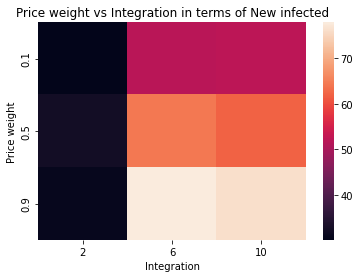

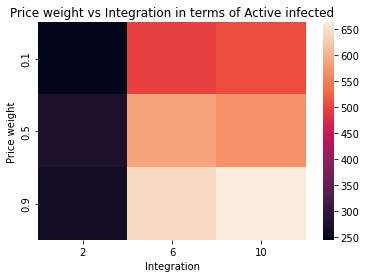

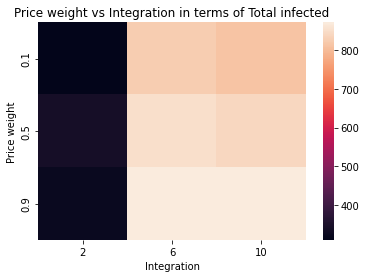

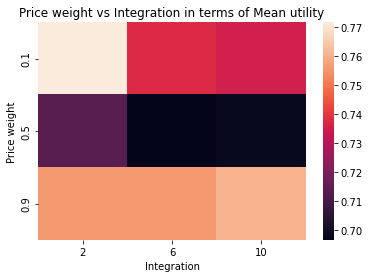

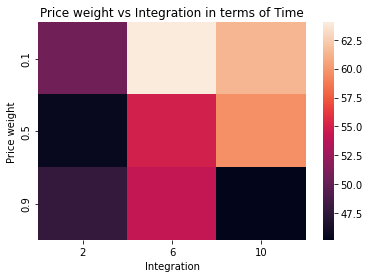

In [ ]:
values = ['New infected', 'Active infected', 'Total infected', 'Mean utility','Time']
def q4(value):
  ##4.a
  piv = pd.pivot(mean.reset_index(), "Price weight", "Integration", value)

  ##4.b
  fig, ax = plt.subplots()


  ##4.c
  sns.heatmap(piv, ax=ax)

  ##4.d
  ax.set_title(f"Price weight vs Integration in terms of {value}")

  ##4.h
  fig.savefig(f"/content/drive/My Drive/Studies/3d, 1st/Urban Simulation/ex4/vis/heatmap_{value}.png")

for value in values:
  q4(value)

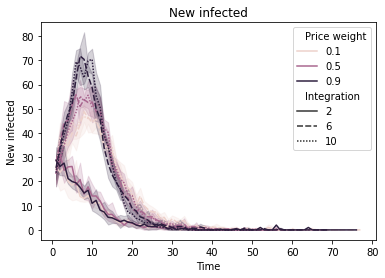

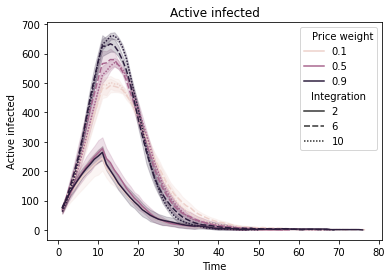

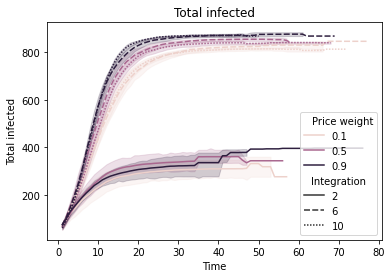

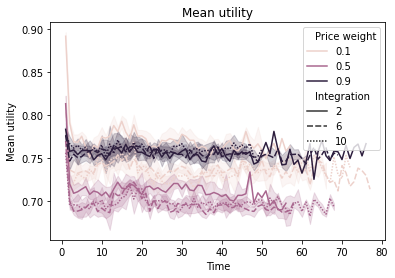

In [ ]:
#5
values_5 = ['New infected', 'Active infected', 'Total infected', 'Mean utility']
def q5(value):

  ##5.a
  fig, ax = plt.subplots()


  ##5.b
  sns.lineplot(data=df, x="Time", y=value, hue="Price weight", style="Integration", ax=ax)

  ##5.c
  ax.set_title(f"{value}")

  ##5.d
  fig.savefig(f"/content/drive/My Drive/Studies/3d, 1st/Urban Simulation/ex4/vis/lineplot_{value}.png")
  # fig.show()

for value in values_5:
  q5(value)

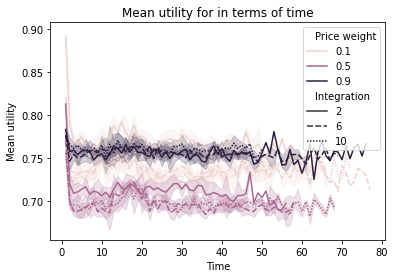

In [ ]:
fig, ax = plt.subplots()


  ##4.b
sns.lineplot(data=df, x="Time", y="Mean utility", hue="Price weight", style="Integration",ax=ax)

##4.d
ax.set_title(f"Mean utility for in terms of time")

##4.h
# fig.savefig(f"/content/drive/My Drive/Studies/3d, 1st/Urban Simulation/ex4/vis/heatmap_{value}.png")
fig.show()